In [142]:
import sys
sys.path.append('../')

import glob

from typing import Tuple, Union, List
import pandas as pd
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm as tqdm

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample as ho_sample

import torch
import torch.nn as nn

import torch_geometric as pyg
from torch_geometric.utils.convert import from_networkx
from torch_geometric.data import InMemoryDataset
import torch_scatter

from src.utils import *
from dataset import *
from src.train import train, test
from src.dataloaders import make_dataloaders_from_dataset
from src.model import BaseEstimator, KnnEstimator

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from IPython.display import clear_output

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(17)

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
G = nx.readwrite.read_gpickle('data/network32.gpickle')

In [144]:
# Pytorch geometric Data object. For now used only for storing node embedding. 
# Supposed to be used in the future for obtaining node embeddings.
pyg_data = from_networkx(G, group_node_attrs=['embedding'])
pyg_data.to(device)

Data(edge_index=[2, 442], id=[233], lat=[233], lon=[233], population=[233], jobs=[233], labor_force_rate=[233], housing_sales_num_Total:=[233], housing_sales_num_Total:!!Less than $10,000=[233], housing_sales_num_Total:!!$10,000 to $14,999=[233], housing_sales_num_Total:!!$15,000 to $19,999=[233], housing_sales_num_Total:!!$20,000 to $24,999=[233], housing_sales_num_Total:!!$25,000 to $29,999=[233], housing_sales_num_Total:!!$30,000 to $34,999=[233], housing_sales_num_Total:!!$35,000 to $39,999=[233], housing_sales_num_Total:!!$40,000 to $49,999=[233], housing_sales_num_Total:!!$50,000 to $59,999=[233], housing_sales_num_Total:!!$60,000 to $69,999=[233], housing_sales_num_Total:!!$70,000 to $79,999=[233], housing_sales_num_Total:!!$80,000 to $89,999=[233], housing_sales_num_Total:!!$90,000 to $99,999=[233], housing_sales_num_Total:!!$100,000 to $124,999=[233], housing_sales_num_Total:!!$125,000 to $149,999=[233], housing_sales_num_Total:!!$150,000 to $174,999=[233], housing_sales_num_T

In [145]:
knn_edge_index = pyg.nn.knn_graph(pyg_data.x, k=10, cosine=True)
knn_edge_index.shape

torch.Size([2, 2330])

In [146]:
knn_edge_index[:, knn_edge_index[0] == 9]

tensor([[  9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   9],
        [ 22,  35,  41,  44,  57, 116, 120, 123, 128, 145, 208]],
       device='cuda:0')

In [147]:
from catboost import CatBoostRegressor
scaler = CatBoostRegressor()
scaler.load_model('models_data/catboost_scaler.dat')

In [194]:
class BasicLocationScaler(nn.Module):
    def __call__(self, X):
        return X


class ExtrapolationLayer(pyg.nn.MessagePassing):
    def __init__(self, in_channels, out_channels=1, hidden_channels=16, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.hidden_channels = hidden_channels
        self.lin = nn.Linear(self.in_channels, self.hidden_channels)
        self.loc_scaler = BasicLocationScaler()
        # self.scaler = CatBoostRegressor()
        # self.scaler.load_model('models_data/catboost_scaler.dat')
    

    def forward(self, obs_emb, obs_scaling_features, obs_targets, q_emb, q_scaling_features, edge_index):
        # print(obs_emb.shape)
        # print(q_emb.shape)
        # print(obs_scaling_features.shape)
        # print(q_scaling_features.shape)
        # print(obs_targets.shape)

        scale_obs = self.loc_scaler(obs_scaling_features)
        scale_q = self.loc_scaler(q_scaling_features)

        obs_emb = self.lin(obs_emb)
        q_emb = self.lin(q_emb)

        q_size = len(q_emb)
        obs_size = len(obs_emb)

        # print(scale_obs)
        # print(scale_q)

        scaled_targets = (obs_targets / scale_obs).reshape(-1, 1)
        # scaled_targets = obs_targets.reshape(-1, 1)
        out = self.propagate(edge_index, x=scaled_targets, emb=(obs_emb, q_emb), size=(obs_size, q_size))
        # print(out.shape)
        out = out.reshape(-1)
        out = out * scale_q
        # out = scale_q
        return out


    def message(self, x_j, emb_j, emb_i, index):
        # print(x_j.shape, emb_j.shape, emb_i.shape, index.shape)
        # alpha = torch.sum(emb_j * emb_i, dim=-1)[:, None]
        alpha = torch.cosine_similarity(emb_j, emb_i)[:, None]
        # alpha = torch.ones_like(alpha)
        att_weights = pyg.utils.softmax(alpha, index)
        out = att_weights * x_j
        return out
    
    def aggregate(self, inputs, index):
        return torch_scatter.scatter(inputs, index, dim=0, reduce='sum')


In [195]:
from sklearn.neighbors import NearestNeighbors


class GNNEstimator(BaseEstimator):
    def __init__(self, pyg_graph, nodes, targets, in_channels=32, *args, **kwargs):
        super().__init__(pyg_graph, nodes, targets, *args, **kwargs)

        self.obs_targets = torch.as_tensor(self.obs_targets).to(device)
        self.extrapolation_layer = ExtrapolationLayer(in_channels)    

    def forward(self, nodes, edge_index):
        # here can be possible node features updating
        embeddings = self.g.x
        q_index = np.asarray([int(self.node_to_idx(x)) for x in nodes])

        obs_scaling_features = self.g.mean_target[self.obs_node_indices]
        q_scaling_features = self.g.mean_target[q_index]

        obs_emb = embeddings[self.obs_node_indices]
        q_emb = embeddings[q_index]

        return self.extrapolation_layer(obs_emb, obs_scaling_features, 
            self.obs_targets, q_emb, q_scaling_features, edge_index)
    
    def make_test_edge_index(self, test_graph: pyg.data.Data, neighbors_num=10):
        nneighbors = NearestNeighbors(n_neighbors=neighbors_num, metric='haversine')

        nneighbors.fit(torch.vstack([self.g.lat[self.obs_node_indices],
                                     self.g.lon[self.obs_node_indices]]).T.detach().cpu())

        indices = nneighbors.kneighbors(torch.vstack([test_graph.lat, test_graph.lon]).T.detach().cpu(), 
                return_distance=False)
        
        index = torch.stack((torch.asarray(indices).reshape(-1), 
                             torch.arange(test_graph.num_nodes)[:, None].expand(-1, neighbors_num).reshape(-1)))
        return index

In [196]:
from random import Random

def node_indices_split(nodes_num, train_size=0.7, val_size=0.15, test_size=0.15):
    assert train_size + val_size + test_size == 1.0
    indices = np.arange(nodes_num)
    Random(34).shuffle(indices)
    train, val, test = map(torch.tensor, np.split(indices, [int(nodes_num*train_size), int(nodes_num*(train_size + val_size))]))
    return train, val, test

In [200]:
from tqdm import tqdm as tqdm
from sklearn.metrics import r2_score


def test(model, nodes, targets, edge_index, loss_fn, device) -> Tuple[float, float]:
    """ returns average loss and score
    """
    model.eval()

    total_loss = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        out = model(nodes, edge_index)

        y_gpu = targets.to(device)
        loss = loss_fn(out, y_gpu)

        y_true.extend(targets)
        y_pred.extend(out.detach().cpu())
    
    return loss.item(), r2_score(y_true, y_pred)


def train(model, train_nodes, y_train, train_edge_index, val_nodes, y_val, val_edge_index, loss_fn,
          optimizer, device, scheduler=None, num_epochs=10, plot=True, plot_update_every=5):
    """ returns best model on validation
    """

    train_losses = []
    train_scores = []
    val_losses = []
    val_scores = []

    for epoch in range(num_epochs + 1):
        model.train()

        optimizer.zero_grad()
        out = model(train_nodes, train_edge_index)
        y_train_gpu = y_train.to(device)
        loss = loss_fn(out, y_train_gpu)
        loss.backward()
        optimizer.step()

        # print(y_train, out)
        # fuck()
   
        train_losses.append(loss.item())

        if scheduler is not None:
            scheduler.step()

        train_scores.append(r2_score(out.detach().cpu(), y_train.detach().cpu()))
        val_loss, val_score = test(model, val_nodes, y_val, val_edge_index, loss_fn, device)
        val_losses.append(val_loss)
        val_scores.append(val_score)

        if plot and epoch > 0 and epoch % plot_update_every == 0:
            clear_output(True)
            _, axes = plt.subplots(1, 2, figsize=(20, 6))
            
            sns.lineplot(ax=axes[0], x=range(epoch + 1), y=train_losses, label='Train', color='blue')
            sns.lineplot(ax=axes[0], x=range(epoch + 1), y=val_losses, label='Val', color='red')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].legend()

            sns.lineplot(ax=axes[1], x=range(epoch + 1), y=val_scores, label='Val', color='red')
            sns.lineplot(ax=axes[1], x=range(epoch + 1), y=train_scores, label='Train', color='blue')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Score')
            axes[1].legend()

            plt.show()
            # print(f'Epoch {epoch}, Loss: {train_losses[-1]:.4f}, Val loss: {val_loss:.4f}, Val R2: {val_scores[-1]:.4f}')

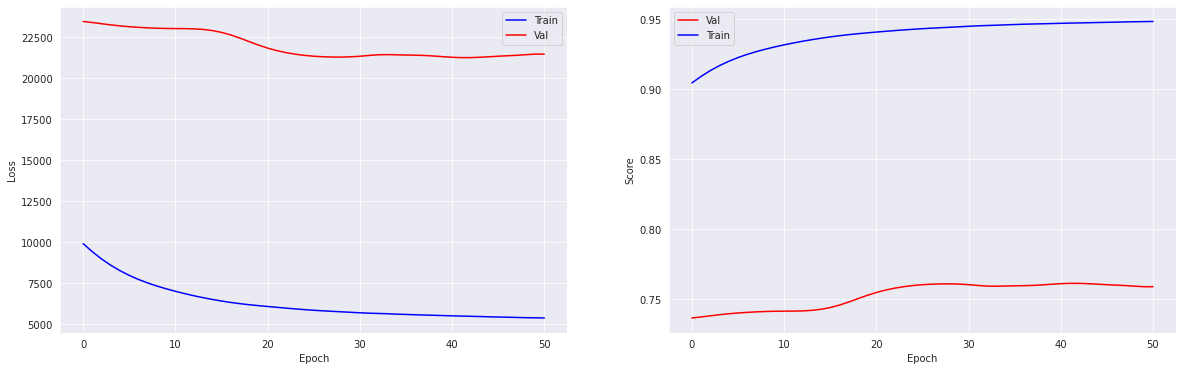

  0%|          | 0/15 [00:02<?, ?it/s]

2021-01-04, Test loss: 15195.8428, test score: 0.8470


In [224]:
results = dict()
loss_fn = nn.MSELoss().to(device)
model = None
NEIGHBORS_NUM = 25

for path in tqdm(glob.glob('datasets/*')[5:20]):
    day = path.split('/')[1].split('.')[0]
    print(day)

    try:
        ds = torch.load(path)
    except:
        continue
    

    train_nodes_idx, val_nodes_idx, test_nodes_idx = node_indices_split(len(ds))
    train_nodes, train_targets = ds[train_nodes_idx]
    val_nodes, val_targets = ds[val_nodes_idx]
    test_nodes, test_targets = ds[test_nodes_idx]
    y_train, y_val, y_test = map(torch.as_tensor, (train_targets, val_targets, test_targets)) 

    train_graph = pyg_data.subgraph(train_nodes_idx)
    print(test_nodes_idx)
    # fuck()
    val_graph = pyg_data.subgraph(val_nodes_idx)
    test_graph = pyg_data.subgraph(test_nodes_idx)

    model = GNNEstimator(pyg_data, train_nodes, train_targets).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    train_edge_index = pyg.nn.knn_graph(train_graph.x, k=NEIGHBORS_NUM, cosine=True) 
    # train_edge_index = torch.vstack((torch.arange(0, len(train_nodes_idx)), torch.arange(0, len(train_nodes_idx)))).to(device)
    print(train_edge_index.shape)
    val_edge_index = model.make_test_edge_index(val_graph, neighbors_num=NEIGHBORS_NUM).to(device)
    test_edge_index = model.make_test_edge_index(test_graph, neighbors_num=NEIGHBORS_NUM).to(device)
    
    train(model, train_nodes, y_train, train_edge_index, val_nodes, y_val, val_edge_index, 
          loss_fn, optimizer, device, num_epochs=50, plot=True, plot_update_every=10)

    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.9)

    test_loss, test_score = test(model, test_nodes, y_test, test_edge_index, loss_fn, device)

    # for name, param in model.named_parameters():
        # print(name, param)

    results[f'{day}'] = test_score 
    print(f'{day}, Test loss: {test_loss:.4f}, test score: {test_score:.4f}')
    break